In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [34]:
# Read the data
data = pd.read_csv('final_processed.csv', index_col=0)

In [35]:
df = data.copy()

df = df[df.sleep_state != -1]

# Binary Classification
df["sleep_state"] = np.where(df["sleep_state"] == 0, 0, 1)

# fill NaN values
df = df.fillna(method='bfill', limit=3000).dropna()

# set column time as datetime index
df['time'] = pd.to_datetime(df['time'])
df = df.set_index('time', drop=True)

In [36]:
# get unique values of the column
df['sleep_state'].unique()

array([0, 1])

# Prcessing

In [37]:
#@title Bandpass Filter
from scipy.signal import butter, sosfilt, sosfreqz


def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order, [low, high], analog=False, btype='band', output='sos')
    return sos


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    sos = butter_bandpass(lowcut, highcut, fs, order=order)
    y = sosfilt(sos, data)
    return y


# apply bandpass filter

fs = 25
lowcut = 0.35
highcut = 5.0


filtered_signal = butter_bandpass_filter(data['ledGreen'].interpolate(),
                                        lowcut,
                                        highcut,
                                        fs,
                                        order=5)


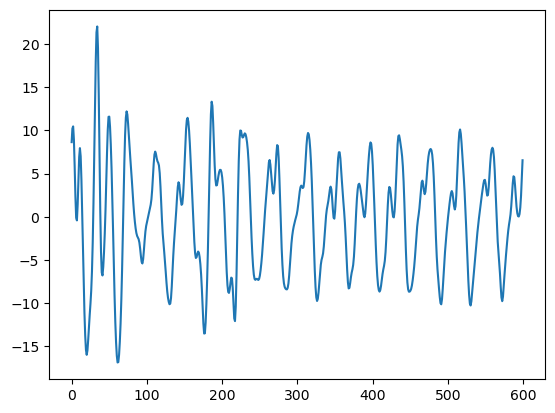

In [38]:
plt.plot(filtered_signal[35000:35600])

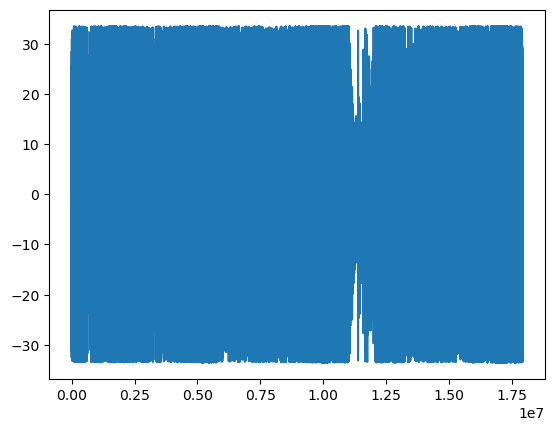

In [39]:
# remove extreme values from the signal (outliers)

def remove_extreme_values(signal, threshold):
    # Compute the absolute difference between the signal and its mean
    absolute_difference = np.abs(signal - np.mean(signal))
    # Compute the median of the absolute difference
    median_absolute_difference = np.median(absolute_difference)
    # Compute the median absolute deviation
    median_absolute_deviation = 1.4826 * median_absolute_difference
    # Compute the z-score
    z_score = 0.6745 * (absolute_difference / median_absolute_deviation)
    # Remove the extreme values
    signal = signal[z_score < threshold]
    return signal


# Example usage
signal = remove_extreme_values(filtered_signal, threshold=3.0)

plt.plot(signal)

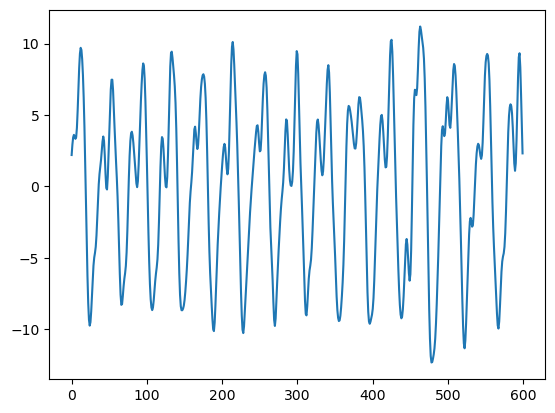

In [40]:
plt.plot(signal[35000:35600])